# Data Preparation

This file contains Python Code used to clean the forum interactions data.

In [1]:
import pandas as pd

In [2]:
df = pd.read_csv("./data/forum/forum_data_sept_2024.csv")
df["topic_id"].unique().size

856

In [3]:
def get_batch_indices(num, batch_size):
    start_indices = list(range(0, num, batch_size))
    end_indices = [min(start + batch_size - 1, num - 1) for start in start_indices]
    batch_numbers = list(range(1, len(start_indices) + 1))
    return start_indices, end_indices, batch_numbers

# Example usage
NUM = 595
BATCH_SIZE = 50
start, end, batch = get_batch_indices(NUM, BATCH_SIZE)

print("START_INDEX =", start)
print("END_INDEX =", end)
print("BATCH_NO =", batch)


START_INDEX = [0, 50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550]
END_INDEX = [49, 99, 149, 199, 249, 299, 349, 399, 449, 499, 549, 594]
BATCH_NO = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]


## Data Cleaning

### Removing Deleted Topics and Posts

In [4]:
professional_written_topic_ids = df[df["post_order"] == 1][df[df["post_order"] == 1]["user_role"] == "Professional"]["topic_id"]

new_df = df.copy()

drop_indices = new_df[new_df["topic_id"].isin(professional_written_topic_ids)].index

new_df = new_df.drop(drop_indices)
new_df = new_df.drop(new_df[new_df["user_id"] == -1].index)
new_df = new_df.drop(new_df[new_df["post_content"].str.contains("(topic deleted by author)")].index)
new_df = new_df.drop(new_df[new_df["post_content"].str.contains("(post deleted by author)")].index)

/var/folders/y_/rndj94rn1vx273fk_jv5p_v80000gn/T/ipykernel_84811/3924387810.py:9: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  new_df = new_df.drop(new_df[new_df["post_content"].str.contains("(topic deleted by author)")].index)
/var/folders/y_/rndj94rn1vx273fk_jv5p_v80000gn/T/ipykernel_84811/3924387810.py:10: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  new_df = new_df.drop(new_df[new_df["post_content"].str.contains("(post deleted by author)")].index)


In [5]:
new_df["topic_id"].unique().size

717

### Remove Topics With No Discussions

These topics only contain a single post, and no one has replied.

In [6]:
single_post_topic_ids = new_df.groupby("topic_id")["post_id"].count().loc[lambda x : x <= 1].index
drop_indices = new_df[new_df["topic_id"].isin(single_post_topic_ids)].index
drop_indices

Index([187, 767], dtype='int64')

In [7]:
new_df = new_df.drop(drop_indices)

In [8]:
new_df["topic_id"].unique().size

715

## Data Selection

We select a subset of the forum data. We first analyse the distribution of word counts in the first post of each topic

In [9]:
word_counts = new_df[new_df["post_order"] == 1]["post_content"].apply(lambda x : len(x.split(" ")))
word_counts

1       100
7        73
14      267
23      137
26      513
       ... 
3273     33
3275     85
3277     49
3280    183
3282     26
Name: post_content, Length: 715, dtype: int64

In [10]:
word_counts.max()

np.int64(1644)

### Understanding The Distribution

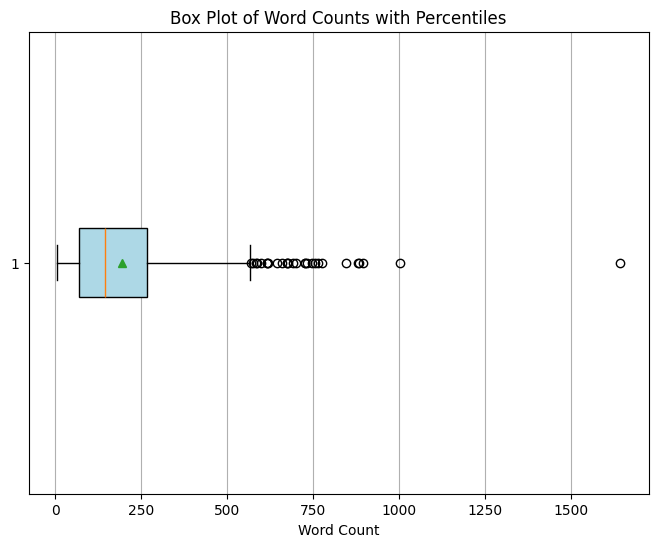

In [11]:
import matplotlib.pyplot as plt

# Create the box plot
plt.figure(figsize=(8, 6))
box = plt.boxplot(word_counts, vert=False, patch_artist=True, showmeans=True, 
                  boxprops=dict(facecolor="lightblue"))

# Extract box plot statistics
stats = {
    "25th Percentile": word_counts.quantile(0.25),  # Q1
    "Median": word_counts.median(),         # Median
    "Mean": word_counts.mean(),             # Mean
    "75th Percentile": word_counts.quantile(0.75),  # Q3
}

# Annotate the box plot
# for label, value in stats.items():
#     plt.text(value, 1, f"{label}: {value:.1f}", va='bottom' if label == "Mean" else 'top', fontsize=10)

# Add labels and title
plt.title("Box Plot of Word Counts with Percentiles")
plt.xlabel("Word Count")
plt.grid(axis='x')

# Display the box plot
plt.show()

In [12]:
word_counts.quantile(0.08)

np.float64(30.0)

In [13]:
word_counts.quantile(0.12)

np.float64(40.0)

In [14]:
word_counts.quantile(0.169)

np.float64(50.0)

In [15]:
word_counts.quantile(0.60)

np.float64(186.0)

In [16]:
stats

{'25th Percentile': np.float64(68.0),
 'Median': np.float64(144.0),
 'Mean': np.float64(194.73846153846154),
 '75th Percentile': np.float64(267.0)}

In [17]:
condition = new_df[new_df["post_order"] == 1]["post_content"].apply(lambda x : len(x.split(" "))) >= 20
condition.value_counts()

post_content
True     687
False     28
Name: count, dtype: int64

In [18]:
condition = new_df[new_df["post_order"] == 1]["post_content"].apply(lambda x : len(x.split(" "))) >= 30
condition.value_counts()

post_content
True     658
False     57
Name: count, dtype: int64

In [19]:
condition = new_df[new_df["post_order"] == 1]["post_content"].apply(lambda x : len(x.split(" "))) >= 40
condition.value_counts()

post_content
True     632
False     83
Name: count, dtype: int64

In [20]:
condition = new_df[new_df["post_order"] == 1]["post_content"].apply(lambda x : len(x.split(" "))) >= 50
condition.value_counts()

post_content
True     595
False    120
Name: count, dtype: int64

In [21]:
condition = new_df[new_df["post_order"] == 1]["post_content"].apply(lambda x : len(x.split(" "))) >= 68
condition.value_counts()

post_content
True     537
False    178
Name: count, dtype: int64

### Selected Condition

In [22]:
condition = new_df[new_df["post_order"] == 1]["post_content"].apply(lambda x : len(x.split(" "))) >= 50
condition.value_counts()

post_content
True     595
False    120
Name: count, dtype: int64

In [23]:
filtered_posts = new_df[new_df["post_order"] == 1][condition]

In [24]:
filtered_posts

,topic_id,topic,url,subcategory,tags,user_id,username,user_role,user_title,post_id,post_order,post_content,links_in_post,num_likes,accepted_ans_post_id,replied_to_post_id,replied_to_post_id_direct,replied_to_post_id_soft,quoted_post_id
1,14809,Mentally isolated,https://letstalk.mindline.sg/t/mentally-isolat...,Is This Normal?,---,12128,Sonja,User,NaN,22902,1,I recently realised that friends and family ar...,NaN,0,22918.0,NaN,NaN,NaN,NaN
7,15133,How to cope with mistakes at work?,https://letstalk.mindline.sg/t/how-to-cope-wit...,Seeking Help,needadvice,12317,user1306,User,NaN,23644,1,I’ve been making few mistakes for the past 2 m...,NaN,0,NaN,NaN,NaN,NaN,NaN
14,15409,Counselling,https://letstalk.mindline.sg/t/counselling/15409,Is This Normal?,---,12564,anonymous394,User,NaN,24064,1,I’ve been feeling low and suicidal for some ti...,NaN,1,NaN,NaN,NaN,NaN,NaN
23,15434,overthinking please help,https://letstalk.mindline.sg/t/overthinking-pl...,Coping,---,12578,user1322,User,NaN,24114,1,I keep overthinking and im not sure how to sto...,NaN,0,NaN,NaN,NaN,NaN,NaN
26,15430,I’m exhausted,https://letstalk.mindline.sg/t/im-exhausted/15430,Seeking Help,---,12577,SLCBY,User,NaN,24107,1,I am tired. I feel down everyday. No mood in d...,NaN,0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3257,422,Is it okay for me to feel this way?,https://letstalk.mindline.sg/t/is-it-okay-for-...,Is This Normal?,---,109,choc_kitkat,User,NaN,666,1,"After seeking help from counsellors at TP, I f...",NaN,0,NaN,NaN,NaN,NaN,NaN
3260,481,Feeling Burnt Out,https://letstalk.mindline.sg/t/feeling-burnt-o...,Seeking Help,---,104,strawberryshortcake,User,NaN,782,1,It feels like the semester has just started no...,NaN,0,NaN,NaN,NaN,NaN,NaN
3271,424,I feel so lonely at nights,https://letstalk.mindline.sg/t/i-feel-so-lonel...,Is This Normal?,---,94,Kitty,User,NaN,669,1,I’m naturally an introvert and don’t like to t...,NaN,4,NaN,NaN,NaN,NaN,NaN
3275,397,Thinking about the first step,https://letstalk.mindline.sg/t/thinking-about-...,Seeking Help,---,82,Irsdi,User,NaN,628,1,Is it normal for me to hesitate to seek for pr...,NaN,1,NaN,NaN,NaN,NaN,NaN


### Get The Filtered Topic IDs and Create Forum Dataframe For Dialogue Generation

In [25]:
filtered_topic_ids = filtered_posts["topic_id"].unique().tolist()

In [26]:
len(filtered_topic_ids)

595

In [27]:
new_df_filtered = new_df[new_df["topic_id"].isin(filtered_topic_ids)]

In [28]:
new_df_filtered 

,topic_id,topic,url,subcategory,tags,user_id,username,user_role,user_title,post_id,post_order,post_content,links_in_post,num_likes,accepted_ans_post_id,replied_to_post_id,replied_to_post_id_direct,replied_to_post_id_soft,quoted_post_id
1,14809,Mentally isolated,https://letstalk.mindline.sg/t/mentally-isolat...,Is This Normal?,---,12128,Sonja,User,NaN,22902,1,I recently realised that friends and family ar...,NaN,0,22918.0,NaN,NaN,NaN,NaN
2,14809,Mentally isolated,https://letstalk.mindline.sg/t/mentally-isolat...,Is This Normal?,---,11047,CaringBee,Professional,The Source of Comfort,22918,2,Hi Sonja\nThank you for your courage to reach ...,NaN,0,NaN,NaN,NaN,NaN,NaN
3,14809,Mentally isolated,https://letstalk.mindline.sg/t/mentally-isolat...,Is This Normal?,---,12128,Sonja,User,NaN,24145,3,Thank you for the much appreciated advice! Sad...,NaN,0,NaN,NaN,NaN,NaN,NaN
4,14809,Mentally isolated,https://letstalk.mindline.sg/t/mentally-isolat...,Is This Normal?,---,12289,terravolt43,User,NaN,24154,4,"Hi Sonja,\nThanks for confiding here. Sorry to...",NaN,0,NaN,NaN,NaN,NaN,NaN
7,15133,How to cope with mistakes at work?,https://letstalk.mindline.sg/t/how-to-cope-wit...,Seeking Help,needadvice,12317,user1306,User,NaN,23644,1,I’ve been making few mistakes for the past 2 m...,NaN,0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3272,424,I feel so lonely at nights,https://letstalk.mindline.sg/t/i-feel-so-lonel...,Is This Normal?,---,61,JasonQ,User,Professional (Moderator),671,2,Hi there; thank you for sharing your situation...,THE BUTTERFLY EFFECT: HOW SMALL CHANGES LEAD T...,0,NaN,NaN,NaN,NaN,NaN
3275,397,Thinking about the first step,https://letstalk.mindline.sg/t/thinking-about-...,Seeking Help,---,82,Irsdi,User,NaN,628,1,Is it normal for me to hesitate to seek for pr...,NaN,1,NaN,NaN,NaN,NaN,NaN
3276,397,Thinking about the first step,https://letstalk.mindline.sg/t/thinking-about-...,Seeking Help,---,61,JasonQ,User,Professional (Moderator),629,2,"Hi there, thank you for raising this question....",13 Tips to Help You Prepare for Your First The...,0,NaN,NaN,NaN,NaN,NaN
3280,312,What do I do in between therapy sessions?,https://letstalk.mindline.sg/t/what-do-i-do-in...,Treatment & Recovery,"mentalhealth, therapy, healing",64,mrpeanutbutter,User,NaN,449,1,"I realise this sounds ridiculous, but my issue...",NaN,0,NaN,NaN,NaN,NaN,NaN


In [29]:
new_df_filtered[new_df_filtered["post_order"] == 1].groupby(["subcategory"])["topic_id"].count()

subcategory
Coping                       88
Is This Normal?             163
Mental Health Conditions     41
Seeking Help                269
Signs and Symptoms           18
Treatment & Recovery         16
Name: topic_id, dtype: int64

In [30]:
new_df_filtered.to_csv("./data/forum/forum_data_for_dialogue_generation.csv", index=False)